# Predictive flow model for Ashford Mill Catchment 


## 1.0 Executive summary

I initially set out to build a predictive model of flow rate in a river based on rainfall data.

I was able to identify that flow rate displayed a lagged response to rainfall and there was a seasonal difference in how flow rate responded to rainfall. I was able to create lagged features that would enable predictions to be made from a single row of data. I created a term from previous temperature data that I used to modify rainfall throughout the season that significantly improved predictions. I tried a range of machine learning techniques using the sklearn and tensorflow python libraries and I was able to create an accurate model that can be used to predict the flow rate in a river from rainfall data.

## 2.0 Getting data from The Environment Agencies API

In this section a full year of data will be obtained, including rainfall data preceding the start of the year. This is so rainfall conditions prior to the start date, in this case '01/01/2019', can be considered. The year 2019 has been chosen arbitrarily.

In [1]:
import requests
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Datetime is a library that allows us to represent dates
import datetime
from datetime import timedelta
from datetime import datetime

import urllib3 
# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt

import statsmodels.tsa.stattools as smt
from statsmodels.tsa.stattools import ccf

Getting Ashford Mill flow rate and rainfall data from 01/01/2019 to 01/01/2020

In [2]:
chard_snowdon_hill_rain_url_2019 = 'https://environment.data.gov.uk/hydrology/id/measures/d1803c5a-e461-404b-8750-7f946456a6c6-rainfall-t-900-mm-qualified/readings.csv?mineq-date=2018-11-01&max-date=2020-01-01'
df_rain_2019 = pd.read_csv(chard_snowdon_hill_rain_url_2019)
df_rain_2019['dateTime'] = pd.to_datetime(df_rain_2019['dateTime'])

In [3]:
url_flow_2019 ='http://environment.data.gov.uk/hydrology/id/measures/404429da-b05c-4c95-98ee-4941b2133cb6-flow-i-900-m3s-qualified/readings.csv?mineq-date=2019-01-01&max-date=2020-01-01'
df_flow_2019 = pd.read_csv(url_flow_2019)
df_flow_2019['dateTime'] = pd.to_datetime(df_flow_2019['dateTime'])

In [4]:
df_flow_2019.head()

,measure,dateTime,date,value,completeness,quality,qcode
0,http://environment.data.gov.uk/hydrology/id/measures/404429da-b05c-4c95-98ee-4941b2133cb6-flow-i-900-m3s-qualified,2019-01-01 00:00:00,2019-01-01,0.967,NaN,Good,NaN
1,http://environment.data.gov.uk/hydrology/id/measures/404429da-b05c-4c95-98ee-4941b2133cb6-flow-i-900-m3s-qualified,2019-01-01 00:15:00,2019-01-01,0.959,NaN,Good,NaN
2,http://environment.data.gov.uk/hydrology/id/measures/404429da-b05c-4c95-98ee-4941b2133cb6-flow-i-900-m3s-qualified,2019-01-01 00:30:00,2019-01-01,0.959,NaN,Good,NaN
3,http://environment.data.gov.uk/hydrology/id/measures/404429da-b05c-4c95-98ee-4941b2133cb6-flow-i-900-m3s-qualified,2019-01-01 00:45:00,2019-01-01,0.959,NaN,Good,NaN
4,http://environment.data.gov.uk/hydrology/id/measures/404429da-b05c-4c95-98ee-4941b2133cb6-flow-i-900-m3s-qualified,2019-01-01 01:00:00,2019-01-01,0.959,NaN,Good,NaN


There is a lot of information I do not need, so I can remove the unnecessary columns.

In [5]:
df_flow_2019.set_index('dateTime', inplace=True)
df_rain_2019.set_index('dateTime', inplace=True)
df_rain_2019 = df_rain_2019.drop(columns=['measure', 'date','qcode', 'completeness', 'quality'])
df_flow_2019 = df_flow_2019.drop(columns=['measure', 'date','qcode', 'completeness', 'quality'])

In [6]:
df_rain_2019['flow_rate'] = df_flow_2019.loc['2019-01-01 00:00:00':'2019-12-31 23:00:00', 'value'].copy(deep = True)

In [7]:
df_rain_2019 = df_rain_2019.loc['2019-01-01 00:00:00':'2019-12-31 23:00:00']

In [8]:
df_rain_2019_hrs = df_rain_2019['value'].resample('1H').sum()
df_rain_2019_hrs = pd.DataFrame(df_rain_2019_hrs, columns = ['value'])

In [9]:
df_flow_2019_hrs = df_flow_2019.resample('1H').mean()
df_flow_2019_hrs = pd.DataFrame(df_flow_2019_hrs, columns = ['flow_rate'])

In [10]:
df_rain_2019_hrs['flow_rate'] = df_flow_2019.loc['2019-01-01 00:00:00':'2019-12-31 23:00:00', 'value'].copy(deep = True)

In [11]:
df_rain_2019_hrs.head()

,value,flow_rate
dateTime,,
2019-01-01 00:00:00,0.0,0.967
2019-01-01 01:00:00,0.0,0.959
2019-01-01 02:00:00,0.0,0.950
2019-01-01 03:00:00,0.0,0.932
2019-01-01 04:00:00,0.0,0.923


In [12]:
df_rain_2019.head()

,value,flow_rate
dateTime,,
2019-01-01 00:00:00,0.0,0.967
2019-01-01 00:15:00,0.0,0.959
2019-01-01 00:30:00,0.0,0.959
2019-01-01 00:45:00,0.0,0.959
2019-01-01 01:00:00,0.0,0.959


#### Success! we have some data. 

## 3.0 Visualising the data and doing some initial exploratory data analysis (EDA)

Now I want to visualise the data to see what patterns there are.

In [15]:
def plot_index_2(dfrain, dfflow, rain_col, flow_col):

    fig, ax1 = plt.subplots()
    
    
    color = 'tab:red'
    ax1.set_xlabel('date')
    ax1.set_ylabel('Rainfall (mm)', color=color)  # we already handled the x-label with ax1
    ax1.plot(dfrain.index, dfrain[rain_col], color=color, label = 'rainfall')
    ax1.legend(loc = 'upper left')
    ax1.grid(visible = True, which = 'both')
    ax1.tick_params(axis='y', labelcolor=color)
    plt.setp( ax1.xaxis.get_majorticklabels(), rotation=45 )
    
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Flow rate (m${^3}$/s)', color=color)
    ax2.plot(dfflow.index, dfflow[flow_col], color='tab:blue', label = 'actual flow rate')  #ACTUAL FLOW RATE-------------
    ax2.legend(loc = 'upper right')
    ax2.tick_params(axis='y', labelcolor=color)
    plt.setp( ax2.xaxis.get_majorticklabels(), rotation=45 )
    
    plt.rcParams["figure.figsize"] = (10,6)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [19]:
def plot_index_3(dfrain, dfflow, dfsignal, rain_col, flow_col, signal_col):

    fig, ax1 = plt.subplots()
    #plt.figure(figsize=(10,6))

    color = 'tab:red'
    ax1.set_xlabel('date')
    ax1.set_ylabel('Rainfall (mm)', color=color)  # we already handled the x-label with ax1
    ax1.plot(dfrain.index, dfrain[rain_col], color=color, label = rain_col)  #DATA-------------
    ax1.legend(loc = 'upper left')
    ax1.grid(visible = True, which = 'both')
    ax1.tick_params(axis='y', labelcolor=color)
    plt.setp( ax1.xaxis.get_majorticklabels(), rotation=45 )
    
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Flow rate (m${^3}$/s)', color=color)
    ax2.plot(dfflow.index, dfflow[flow_col], color='tab:blue', label = flow_col)  #DATA-------------
    ax2.plot(dfsignal.index, dfsignal[signal_col], color='tab:green', label = signal_col)  #DATA-------------
    ax2.legend(loc = 'upper right')
    ax2.tick_params(axis='y', labelcolor=color)
    plt.setp( ax2.xaxis.get_majorticklabels(), rotation=45 )
    
    plt.rcParams["figure.figsize"] = (10,6)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

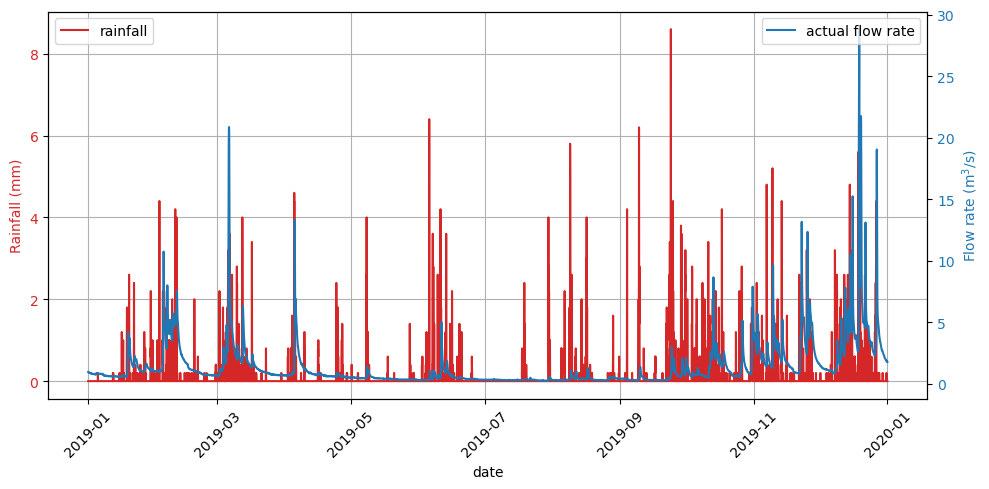

In [16]:
 plot_index_2(df_rain_2019_hrs, df_rain_2019_hrs, 'value', 'flow_rate')

This is a good overview but its hard to see much detail here. Lets filter the data. 

In [20]:
#Function to filter the data

def filter2019_1tab(df_rain, col_rain, col_flow, datemin, datemax):
    filter_for_rain_start= datetime.strptime(datemin, '%Y-%m-%d %H:%M:%S')
    filter_for_rain_stop= datetime.strptime(datemax, '%Y-%m-%d %H:%M:%S')
    x = df_rain[(df_rain.index > datemin) & (df_rain.index < datemax)]
    return x 

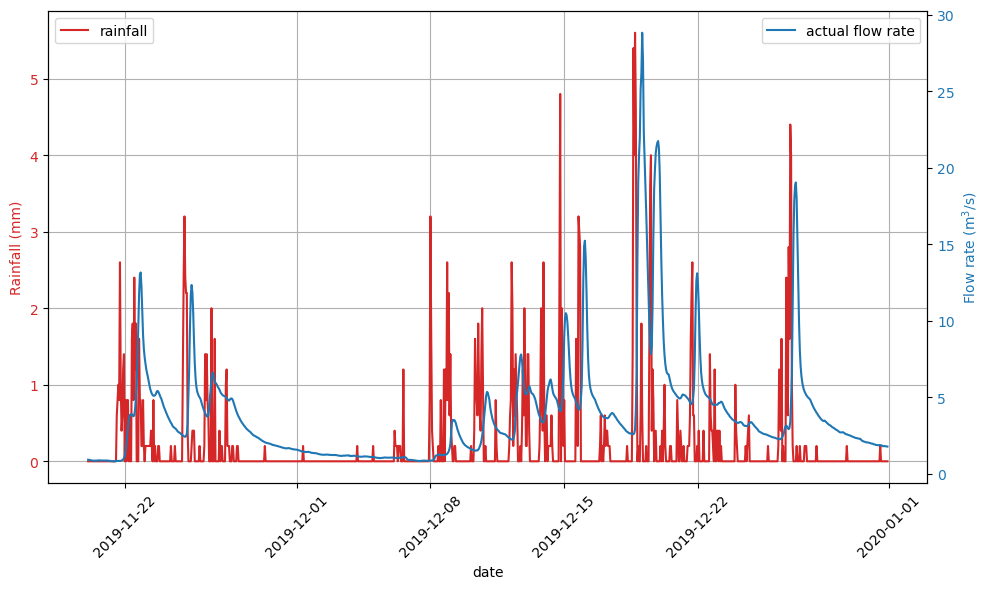

In [21]:
df_filtered2_hrs = filter2019_1tab(df_rain_2019_hrs, 'value', 'flow_rate',  '2019-11-20 01:00:00', '2019-12-31 23:00:00')
plot_index_2(df_filtered2_hrs, df_filtered2_hrs, 'value', 'flow_rate')

This is good but I want to see more detail. We can see from this graph that after the rainfall event at the end of November is takes over 2 weeks for the flow to return near to the previous flow rate even though there was relatively little rainfall after the event.

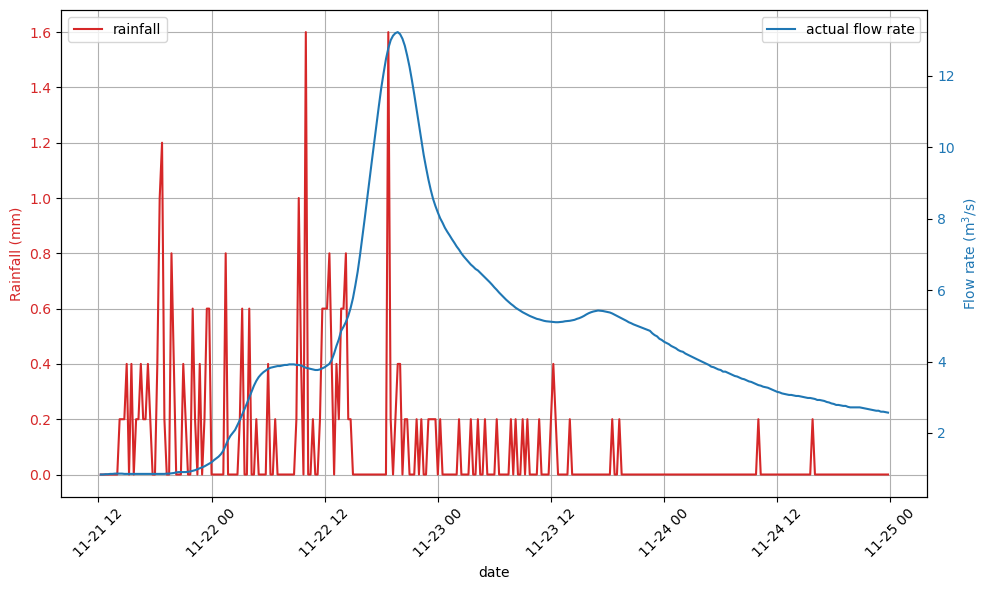

In [22]:
df_filtered_hrs = filter2019_1tab(df_rain_2019, 'value', 'flow_rate',  '2019-11-21 12:00:00', '2019-11-25 00:00:00')
plot_index_2(df_filtered_hrs, df_filtered_hrs, 'value', 'flow_rate')

That is better. From this we can see that there is a lagged response between rainfall and flow rate. It is also clear that there are times when the flow rate is high but rainfall is zero. Therefore it is not going to be possible to predict current flow rate from current rainfall data. I will have to use past lags of rainfall. It is also possible to see that the flow rate does not return to the original flow rate even days later.

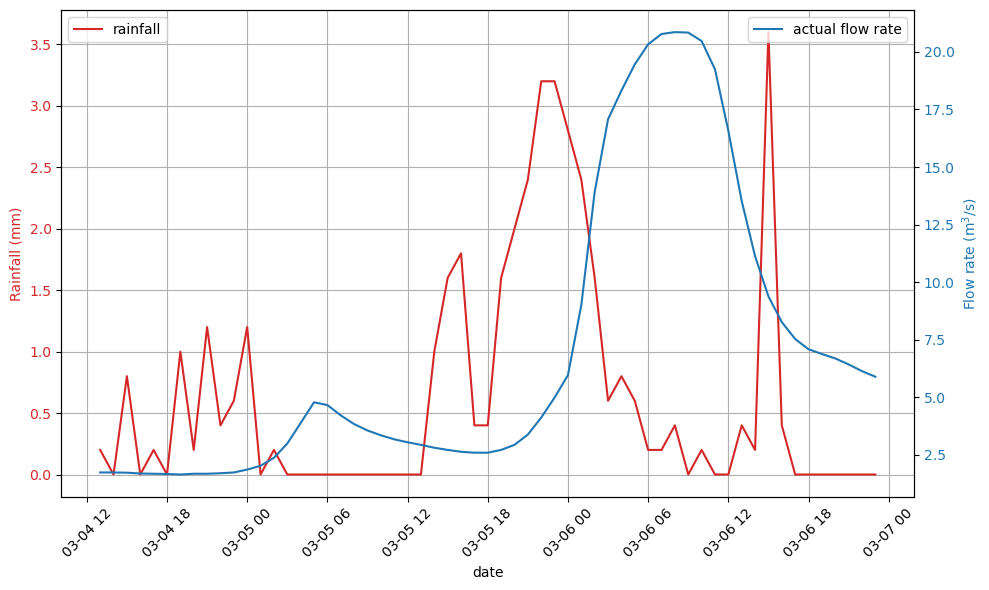

In [23]:
df_filtered_hrs = filter2019_1tab(df_rain_2019_hrs, 'value', 'flow_rate',  '2019-03-04 12:00:00', '2019-03-07 00:00:00')
plot_index_2(df_filtered_hrs, df_filtered_hrs, 'value', 'flow_rate')

This data has been resampled at 1 hour intervals instead of 15 minutes. The rainfall was summed and the flow rate was averaged over this period. See my 'filter_rate' document on https://github.com/800-series for details about why this rate was chosen. In brief this rate doesn't loose much accuracy but does appear to make rainfall more representative of flow rate. 

From this graph there is about a 6 - 12hr delay in increase in rainfall to an increase in flow rate and a slightly longer lag between a decrease in rainfall to a decrease in flow rate.

Lets find out a bit more about the data.

In [24]:
df_rain_2019_hrs.describe()

,value,flow_rate
count,8760.000000,8760.000000
mean,0.127443,1.407079
std,0.473762,2.012208
min,0.000000,0.222000
25%,0.000000,0.400000
50%,0.000000,0.724000
75%,0.000000,1.526000
max,8.600000,28.813000


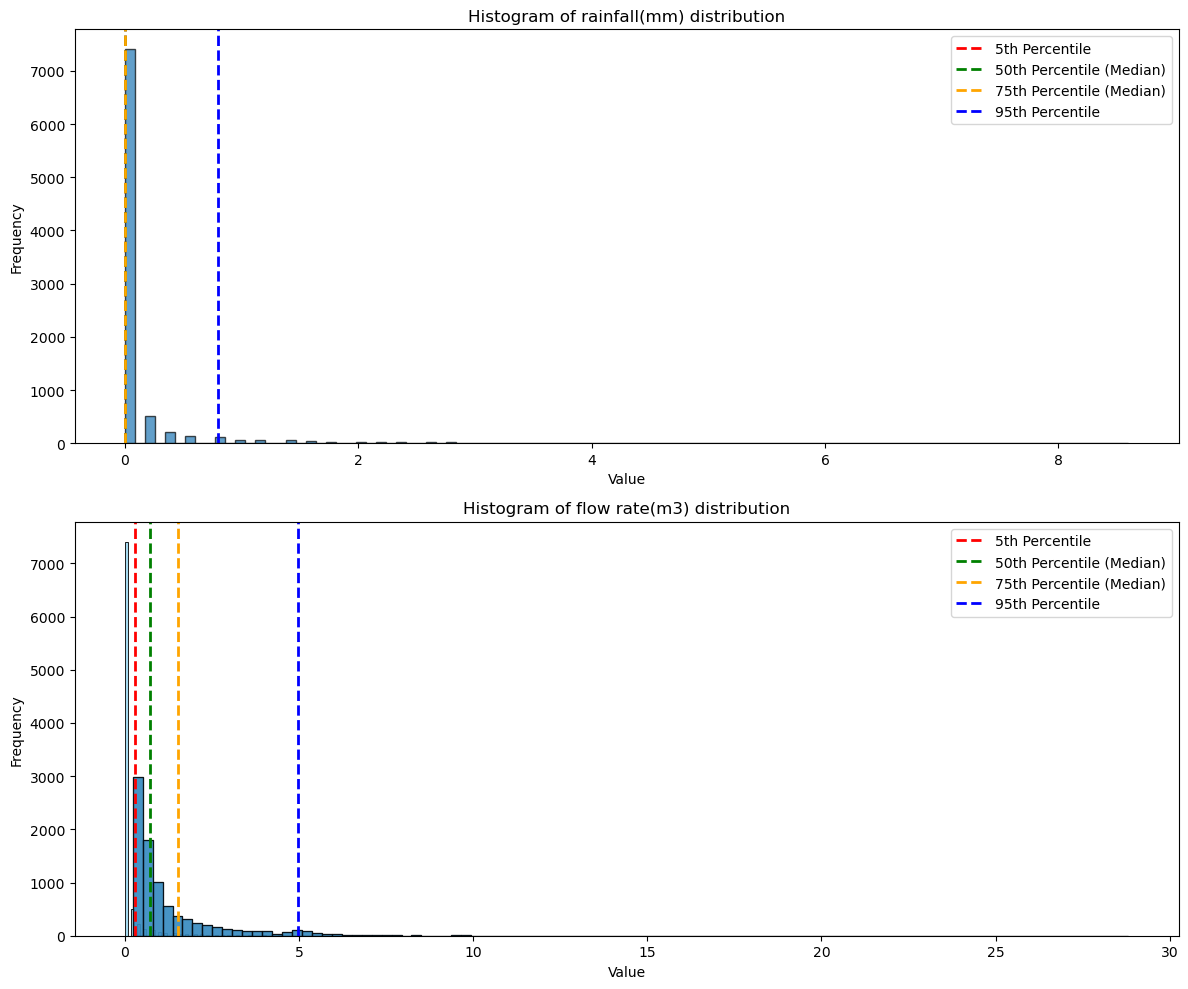

In [25]:
import seaborn as sns

# Create a subplot with one row and two columns
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Plot the percentile histogram with pyplot in the first cell
sns.histplot(df_rain_2019_hrs['value'], bins=100, kde=False, color='skyblue', edgecolor='black')
axs[0].hist(df_rain_2019_hrs['value'].values, bins=100, edgecolor='black', alpha=0.7)
axs[0].axvline(np.percentile(df_rain_2019_hrs['value'].values, 5), color='red', linestyle='dashed', linewidth=2, label='5th Percentile')
axs[0].axvline(np.percentile(df_rain_2019_hrs['value'].values, 50), color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
axs[0].axvline(np.percentile(df_rain_2019_hrs['value'].values, 75), color='orange', linestyle='dashed', linewidth=2, label='75th Percentile (Median)')
axs[0].axvline(np.percentile(df_rain_2019_hrs['value'].values, 95), color='blue', linestyle='dashed', linewidth=2, label='95th Percentile')
axs[0].legend()
axs[0].set_title('Histogram of rainfall(mm) distribution')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

# Plot the percentile histogram with seaborn in the second cell
sns.histplot(df_rain_2019_hrs['flow_rate'], bins=100, kde=False, color='skyblue', edgecolor='black')
axs[1].hist(df_rain_2019_hrs['flow_rate'].values, bins=100, edgecolor='black', alpha=0.7)
axs[1].axvline(np.percentile(df_rain_2019_hrs['flow_rate'].values, 5), color='red', linestyle='dashed', linewidth=2, label='5th Percentile')
axs[1].axvline(np.percentile(df_rain_2019_hrs['flow_rate'].values, 50), color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
axs[1].axvline(np.percentile(df_rain_2019_hrs['flow_rate'].values, 75), color='orange', linestyle='dashed', linewidth=2, label='75th Percentile (Median)')
axs[1].axvline(np.percentile(df_rain_2019_hrs['flow_rate'].values, 95), color='blue', linestyle='dashed', linewidth=2, label='95th Percentile')
axs[1].legend()
axs[1].set_title('Histogram of flow rate(m3) distribution')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')
#Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

Here we can see that the distibutions are very skewed  with more than 75% of rainfall values being zero. Flowrate values do not meet zero but are mostly skewed towards the lower end.

Text(0, 0.5, 'flow rate (m3)')

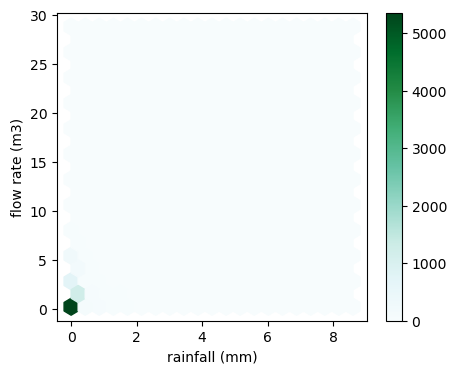

In [26]:
#fig, axs = plt.subplots(2, 1, figsize=(12, 10))
ax = df_rain_2019_hrs.plot.hexbin(x='value', y='flow_rate',
                                 gridsize=20, sharex=False, figsize=(5,4))
ax.set_xlabel('rainfall (mm)')
ax.set_ylabel('flow rate (m3)')

#### This plot shows most of the rainfall data is grouped at around 0. 

Text(0, 0.5, 'flow rate (m3)')

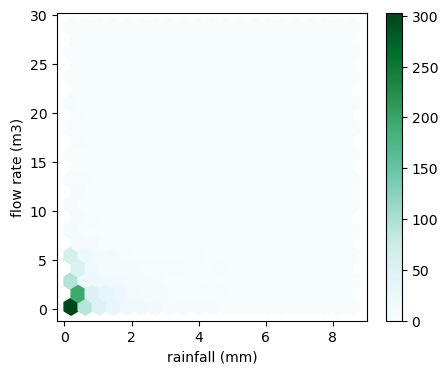

In [27]:
#lets filter out the zero rainfall events to see if this improves
ax = df_rain_2019_hrs[df_rain_2019_hrs['value'] > 0].plot.hexbin(x='value', y='flow_rate',
                                 gridsize=20, sharex=False, figsize=(5,4))
ax.set_xlabel('rainfall (mm)')
ax.set_ylabel('flow rate (m3)')

## 4.0 Prediction with linear regression

Lets start trying to predict flow rate from rainfall using a linear regression model with no lags as a baseline.

In [28]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn import preprocessing

X = df_rain_2019_hrs[['value']]
y = df_rain_2019_hrs['flow_rate']

X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.3, random_state=42)

# creating a regression model 
model = LinearRegression() 
  
# fitting the model 
model.fit(X_train, y_train)

# making predictions 
predictions = model.predict(X_test) 
  
# model evaluation 
print('mean_squared_error : ', mean_squared_error(y_test, predictions)) 
print('mean_absolute_error : ', mean_absolute_error(y_test, predictions))

mean_squared_error :  4.422835057361222
mean_absolute_error :  1.1653097012090534


In [29]:
predictions = model.predict(X)
df_results = X
df_results['predicted_flow_rate'], df_results['flow_rate'] = predictions, y

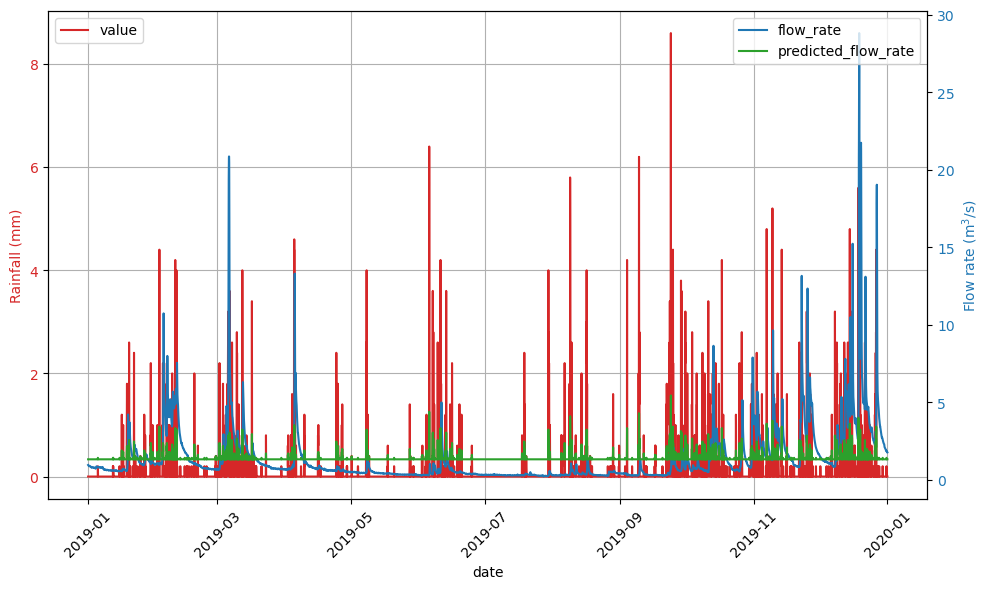

In [30]:
plot_index_3(df_results, df_results, df_results, 'value', 'flow_rate', 'predicted_flow_rate')

This seems to follow the trend of increasing with increased rainfall however there are significant errors.

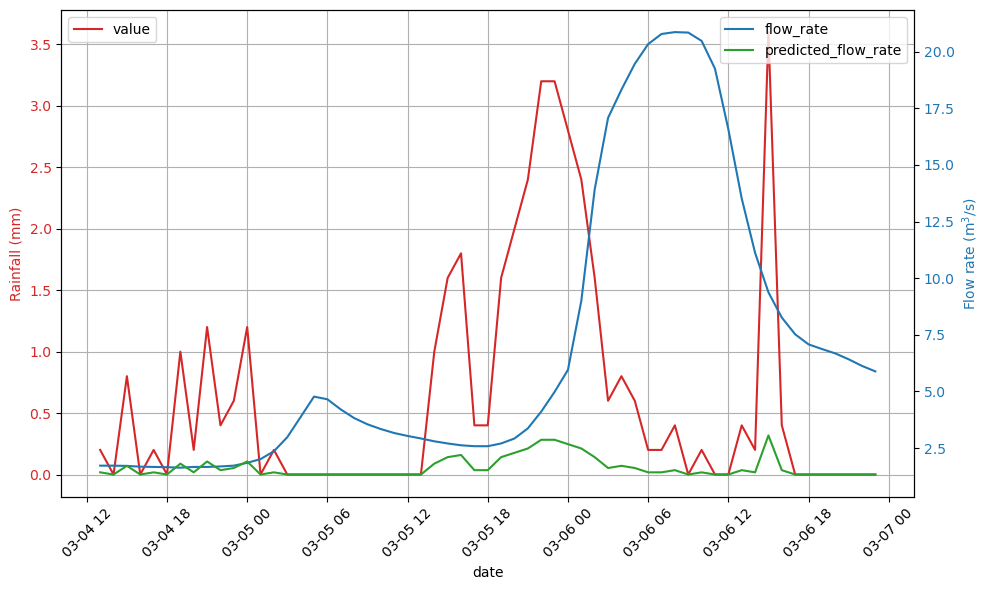

In [31]:
df_filtered_hrs = filter2019_1tab(df_results, 'value', 'flow_rate',  '2019-03-04 12:00:00', '2019-03-07 00:00:00')
plot_index_3(df_filtered_hrs, df_filtered_hrs, df_filtered_hrs, 'value', 'flow_rate', 'predicted_flow_rate')

Here we can see that predicted flow rate significantly under estimates flow rate over this period and the flow rate increases occur when the rainfall increases without the lag.

## 5.0 Creating lagged versions of rainfall to be used as predictors

To build a picture of suitable lags to use we can visualise the correlation of lagged values of rainfall compared to flow rate using statsmodels cross correlation function CCF.

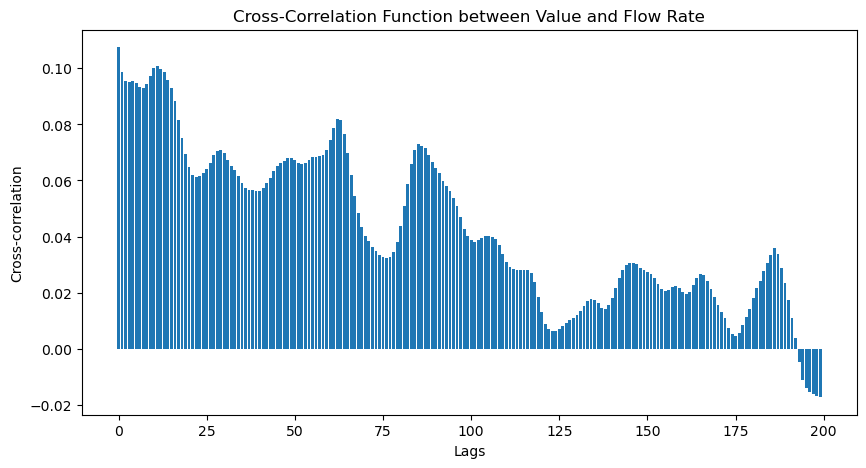

In [32]:
# Compute the cross-correlation function
x = df_rain_2019_hrs['value'].values
y = df_rain_2019_hrs['flow_rate'].values
cross_correlation = ccf(df_rain_2019_hrs['value'], df_rain_2019_hrs['flow_rate'], adjusted=True)
cross_correlation = smt.ccf(x, y, nlags=200,  adjusted=False)
plt.figure(figsize=(10, 5))
lags = range(len(cross_correlation))
plt.bar(lags, cross_correlation)
plt.title('Cross-Correlation Function between Value and Flow Rate')
plt.xlabel('Lags')
plt.ylabel('Cross-correlation')
plt.show()

The first 100 lags show a stronger correlation than subsequent lags with each lag representing 1 hour so this equates to the past 4 days. From section 2.0 it was evident that flow rate takes about 2 weeks to return to a pre rain event level.


Lets create a baseline value using lots of lagged versions to see if it performs well.

In [33]:
#Creating 1hr windows with lags between 4 hrs and 24hrs at 1hr steps
for lag in range(4, 24, 1):
    window_size = 1
    df_rain_2019_hrs[f'shift_{lag}h_window_{window_size}h'] = df_rain_2019_hrs['value'].shift(lag).rolling(window=window_size).apply(lambda s: (s.iloc[0]))

#Creating 2hr windows with lags between 24 hrs and 48hrs at 2hr steps
for lag in range(24, 48, 2):
    window_size = 2
    df_rain_2019_hrs[f'shift_{lag}h_window_{window_size}h'] = df_rain_2019_hrs['value'].shift(lag).rolling(window=window_size).mean()
    
#Creating 24hr windows with lags between 48 hrs and 168hrs at 24hr steps
for lag in range(48, 168, 24):
    window_size = 24
    df_rain_2019_hrs[f'shift_{lag}h_window_{window_size}h'] = df_rain_2019_hrs['value'].shift(lag).rolling(window=window_size).mean()


In [34]:
#Drop all 'NaN' values then check
df_rain_2019_hrs.dropna(axis = 0, inplace = True)
df_rain_2019_hrs.isnull().sum()

value                    0
flow_rate                0
shift_4h_window_1h       0
shift_5h_window_1h       0
shift_6h_window_1h       0
shift_7h_window_1h       0
shift_8h_window_1h       0
shift_9h_window_1h       0
shift_10h_window_1h      0
shift_11h_window_1h      0
shift_12h_window_1h      0
shift_13h_window_1h      0
shift_14h_window_1h      0
shift_15h_window_1h      0
shift_16h_window_1h      0
shift_17h_window_1h      0
shift_18h_window_1h      0
shift_19h_window_1h      0
shift_20h_window_1h      0
shift_21h_window_1h      0
shift_22h_window_1h      0
shift_23h_window_1h      0
shift_24h_window_2h      0
shift_26h_window_2h      0
shift_28h_window_2h      0
shift_30h_window_2h      0
shift_32h_window_2h      0
shift_34h_window_2h      0
shift_36h_window_2h      0
shift_38h_window_2h      0
shift_40h_window_2h      0
shift_42h_window_2h      0
shift_44h_window_2h      0
shift_46h_window_2h      0
shift_48h_window_24h     0
shift_72h_window_24h     0
shift_96h_window_24h     0
s

As one value is based on the value of another we should check for multicolinearity.

In [35]:
# Check for multicolinearity using statsmodels variance_inflation_factor

from statsmodels.stats.outliers_influence import variance_inflation_factor 
feature_columns = [col for col in df_rain_2019_hrs.columns if 'shift_' in col]
X = df_rain_2019_hrs[feature_columns]

# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 

# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 

In [36]:
vif_data

,feature,VIF
0,shift_4h_window_1h,1.678121
1,shift_5h_window_1h,2.135502
2,shift_6h_window_1h,2.148085
3,shift_7h_window_1h,2.149437
4,shift_8h_window_1h,2.148460
5,shift_9h_window_1h,2.149615
6,shift_10h_window_1h,2.147905
7,shift_11h_window_1h,2.148058
8,shift_12h_window_1h,2.148122
9,shift_13h_window_1h,2.148071


This looks OK as the values are below 5 so lets proceed to try a linear regression on this data.

In [37]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn import preprocessing

# X defined above
y = df_rain_2019_hrs['flow_rate']

X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.3, random_state=42)

# creating a regression model 
model = LinearRegression() 
  
# fitting the model 
model.fit(X_train, y_train)

# making predictions 
predictions = model.predict(X_test) 
  
# model evaluation 
print('mean_squared_error : ', mean_squared_error(y_test, predictions)) 
print('mean_absolute_error : ', mean_absolute_error(y_test, predictions))

mean_squared_error :  2.5485964367714065
mean_absolute_error :  0.8259685347387441


In [38]:
predictions = model.predict(X)
df_results = X
df_results['value'] = df_rain_2019_hrs['value'].values
df_results['predicted_flow_rate'], df_results['flow_rate'] = predictions, y

C:\Users\User\AppData\Local\Temp\ipykernel_3064\865195402.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['value'] = df_rain_2019_hrs['value'].values


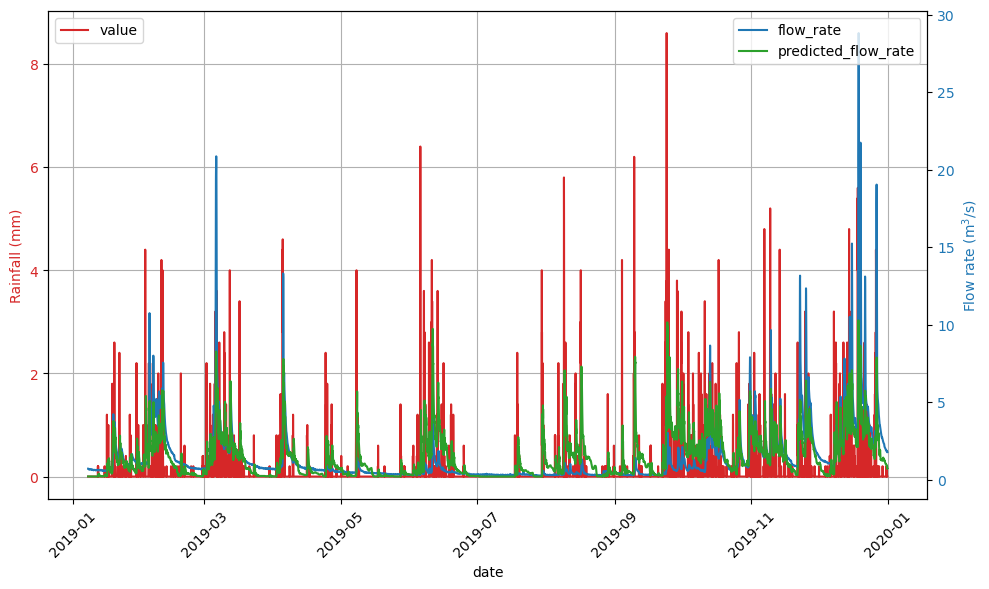

In [39]:
plot_index_3(df_results, df_results, df_results, 'value', 'flow_rate', 'predicted_flow_rate')

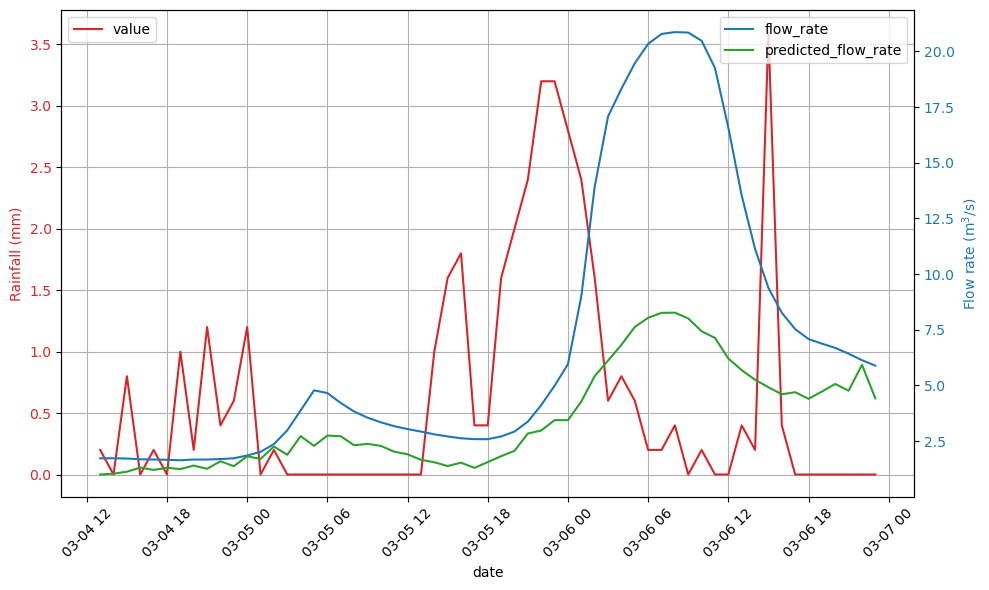

In [40]:
df_filtered_hrs = filter2019_1tab(df_results, 'value', 'flow_rate',  '2019-03-04 12:00:00', '2019-03-07 00:00:00')
plot_index_3(df_filtered_hrs, df_filtered_hrs, df_filtered_hrs, 'value', 'flow_rate', 'predicted_flow_rate')

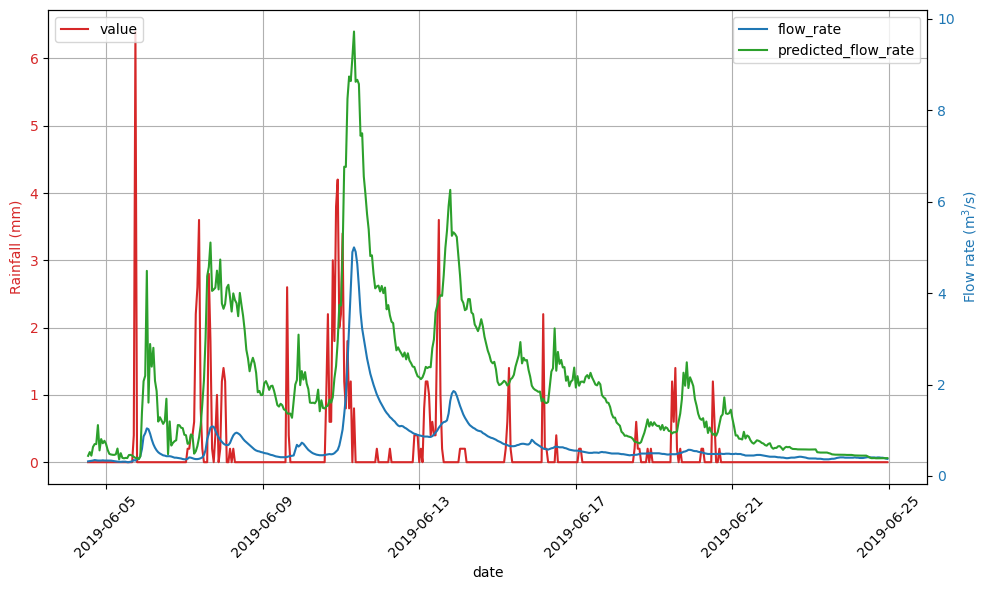

In [41]:
df_filtered_hrs = filter2019_1tab(df_results, 'value', 'flow_rate',  '2019-06-04 12:00:00', '2019-06-25 00:00:00')
plot_index_3(df_filtered_hrs, df_filtered_hrs, df_filtered_hrs, 'value', 'flow_rate', 'predicted_flow_rate')

## 6.0 Discussion of results

OK, the model isn't very accurate so far. 

However what we can see from these results is that the model:

- under predicts flow rate during winter time
- over predicts during summer time

This makes sense as the flow rate is much less responsive to rainfall in summer as the catchment is much drier and the model has tried to find a balance between the two seasons to minimize errors over all. I have not provided the model any terms that could account for this difference in behaviour. 

Additionally I might want to focus on flow rate during high rainfall events rather than low flow. 

One thing to note that is good about this model is that the behaviour of predicted flow generally matches the behaviour of the actual flow rate at about the right time so the model has accounted for the lagged response. 

#### What could we do next

The options vary but include the following:

- Add a term to the model to account for the seasonality
- Create a seasonal factor that measures the error over the season. This might be a good approach if this term is similar thorough out various years, otherwise creating some kind of dryness factor might help.
- Reduce the seasonality by dividing flow rate by the preceding 24hr mean. This has limited benefit as it means future predictions will not be accurate unless we can multiply the predicted results be a seasonal factor to restore the seasonal difference.  
- Train separate models for different times of year
- Apply ridge or lasso regression. 
- Apply Principal Component analysis to get rid of unnecessary terms.
- Apply some different models and see how they perform.


## 7.0 Applying a seasonal term

I will try adding a term that could account for the seasonal difference by obtaining the average temperature over a year.

In [47]:
#Data was obtained from the ceda Midas database available from: https://data.ceda.ac.uk/badc/ukmo-midas-open/data
# This data was stored and loaded from my PC localy.
df_weather_data_2019 = pd.read_csv('C:\\Users\\file_name.csv', header=0)

In [48]:
# Retreive the columns I want. 
df_weather_data_2019 = df_weather_data_2019[['ob_time','air_temperature']]

In [49]:
# We can see the end row needs to be removed. 
df_weather_data_2019.tail()

,ob_time,air_temperature
8756,2019-12-31 20:00:00,7.7
8757,2019-12-31 21:00:00,7.3
8758,2019-12-31 22:00:00,7.4
8759,2019-12-31 23:00:00,7.0
8760,end data,NaN


In [50]:
# Remove the end row
df_weather_data_2019 = df_weather_data_2019.drop(8760, axis = 0)

In [51]:
df_weather_data_2019['ob_time'] = pd.to_datetime(df_weather_data_2019['ob_time'], format = '%Y-%m-%d %H:%M:%S')

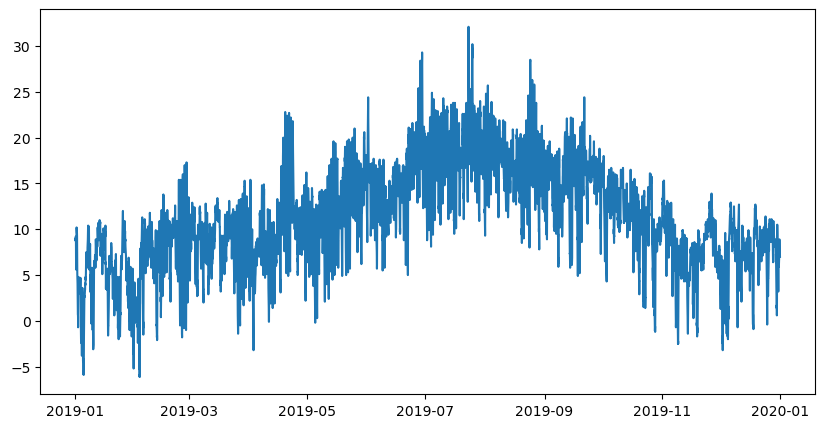

In [367]:
plt.plot(df_weather_data_2019['ob_time'], df_weather_data_2019['air_temperature'])
plt.show()

This is quite chaotic so lets take a rolling monthly average. This data is at 1hr intervals so one month  is 24 x 30 = 720 intervals which will be the window size.

In [52]:
df_weather_data_2019['air_temperature_avr'] = df_weather_data_2019.air_temperature.rolling(window= 720).mean()

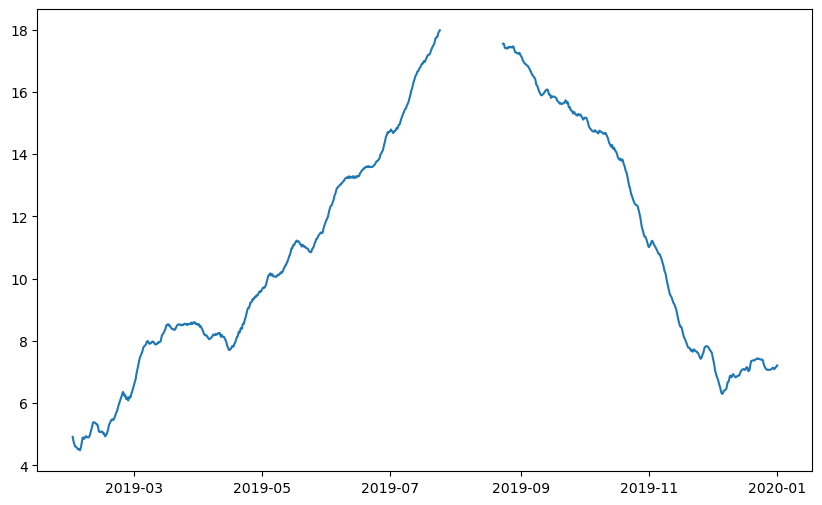

In [53]:
plt.plot(df_weather_data_2019['ob_time'], df_weather_data_2019['air_temperature_avr'])
plt.show()

OK, there is a gap in the data. This may indicate there is a 'NaN' value. I should have checked this first.

In [54]:
df_weather_data_2019.isna().sum()

ob_time                   0
air_temperature           1
air_temperature_avr    1439
dtype: int64

Confirmed! lets locate and fill it. 

In [55]:
df_weather_data_2019[df_weather_data_2019['air_temperature'].isna()== True]

,ob_time,air_temperature,air_temperature_avr
4910,2019-07-24 14:00:00,NaN,NaN


In [56]:
df_weather_data_2019['air_temperature'].iloc[4910] = df_weather_data_2019['air_temperature'].iloc[4909]

C:\Users\User\AppData\Local\Temp\ipykernel_3064\2596571418.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather_data_2019['air_temperature'].iloc[4910] = df_weather_data_2019['air_temperature'].iloc[4909]


In [57]:
#df_weather_data_2019.drop(index=4910, inplace = True)
df_weather_data_2019.isna().sum()

ob_time                   0
air_temperature           0
air_temperature_avr    1439
dtype: int64

In [58]:
df_weather_data_2019['air_temperature_avr'] = df_weather_data_2019.air_temperature.rolling(window= 720).mean()

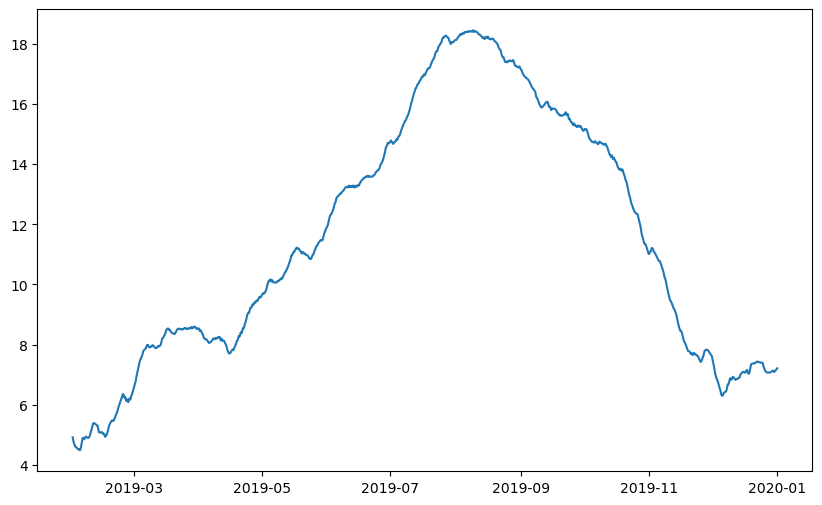

In [59]:
plt.plot(df_weather_data_2019['ob_time'], df_weather_data_2019['air_temperature_avr'])
plt.show()

Excellent! there is now no hole in the data but we are missing a month of data from the beginning where the sample window was not complete. We don't want to loose that much data so instead we want to fill it with the average for the first month.

In [60]:
# Make a variable with the mean of the month of January. 
mean_temp_jan = df_weather_data_2019[df_weather_data_2019['ob_time'].dt.month == 1]['air_temperature'].mean()
mean_temp_jan

4.750537634408602

In [61]:
df_weather_data_2019.fillna(mean_temp_jan, inplace= True)

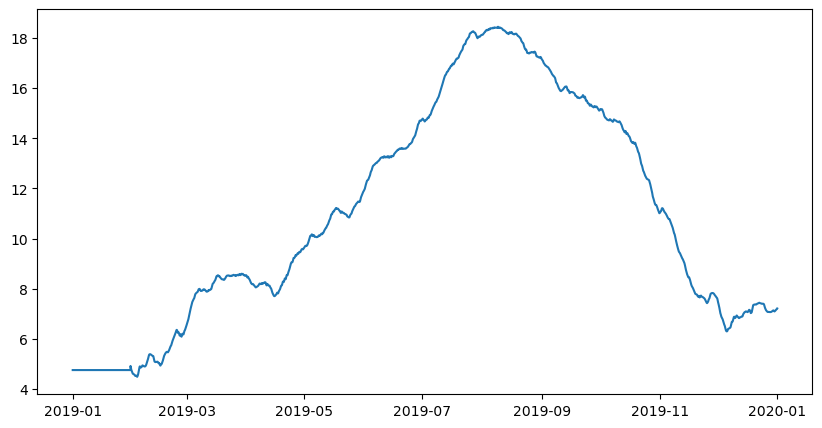

In [378]:
plt.plot(df_weather_data_2019['ob_time'], df_weather_data_2019['air_temperature_avr'])
plt.show()

This looks good now but lets invert the values so that there are high values in winter and low values in summer.

In [62]:
df_weather_data_2019['air_temperature_avr'] = df_weather_data_2019['air_temperature_avr'].apply(lambda s: (5/s)-0.2)

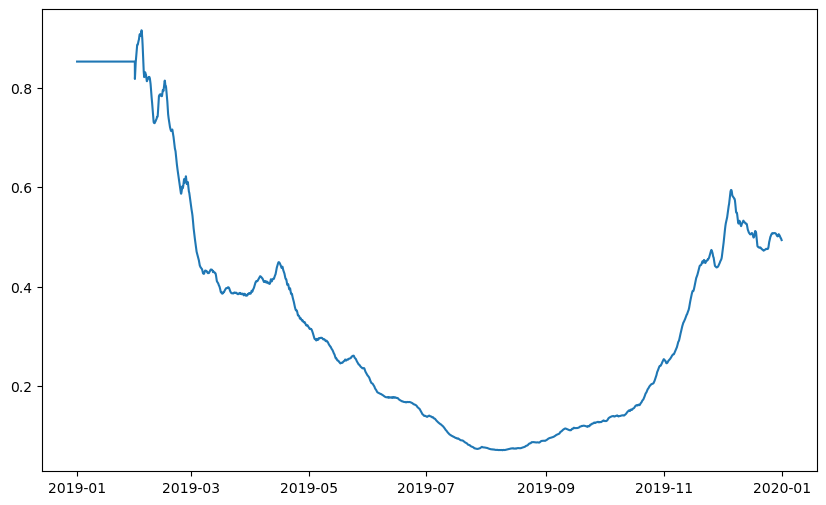

In [63]:
plt.plot(df_weather_data_2019['ob_time'], df_weather_data_2019['air_temperature_avr'])
plt.show()

In [64]:
df_weather_data_2019.shape
# df_weather start  2019-01-01 00:00:00, and end date 2019-12-31 23:00:00, shape (8759, 3)

(8760, 3)

In [65]:
df_weather_data_2019.set_index("ob_time", inplace=True)
df_weather_data_2019.index.rename('dateTime', inplace=True)
df_weather_data_2019

,air_temperature,air_temperature_avr
dateTime,,
2019-01-01 00:00:00,8.8,0.852512
2019-01-01 01:00:00,9.0,0.852512
2019-01-01 02:00:00,8.8,0.852512
2019-01-01 03:00:00,9.0,0.852512
2019-01-01 04:00:00,9.2,0.852512
...,...,...
2019-12-31 19:00:00,7.7,0.495746
2019-12-31 20:00:00,7.7,0.495424
2019-12-31 21:00:00,7.3,0.494967


In [66]:
df_merged= pd.merge(df_rain_2019_hrs, df_weather_data_2019, left_index=True, right_index=True)

In [67]:
df_merged.dropna(axis=0, inplace=True)
df_merged.isna().sum()

value                    0
flow_rate                0
shift_4h_window_1h       0
shift_5h_window_1h       0
shift_6h_window_1h       0
shift_7h_window_1h       0
shift_8h_window_1h       0
shift_9h_window_1h       0
shift_10h_window_1h      0
shift_11h_window_1h      0
shift_12h_window_1h      0
shift_13h_window_1h      0
shift_14h_window_1h      0
shift_15h_window_1h      0
shift_16h_window_1h      0
shift_17h_window_1h      0
shift_18h_window_1h      0
shift_19h_window_1h      0
shift_20h_window_1h      0
shift_21h_window_1h      0
shift_22h_window_1h      0
shift_23h_window_1h      0
shift_24h_window_2h      0
shift_26h_window_2h      0
shift_28h_window_2h      0
shift_30h_window_2h      0
shift_32h_window_2h      0
shift_34h_window_2h      0
shift_36h_window_2h      0
shift_38h_window_2h      0
shift_40h_window_2h      0
shift_42h_window_2h      0
shift_44h_window_2h      0
shift_46h_window_2h      0
shift_48h_window_24h     0
shift_72h_window_24h     0
shift_96h_window_24h     0
s

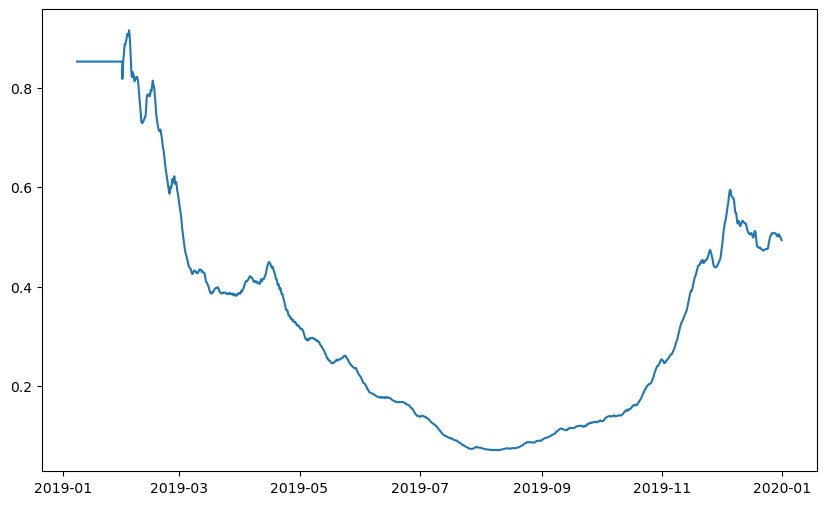

In [68]:
plt.plot(df_merged.index.values, df_merged['air_temperature_avr'])
plt.show()

In [69]:
feature_columns = [col for col in df_merged.columns if 'shift_' in col]
X = df_merged[feature_columns]
X['air_temperature_avr'] = df_merged['air_temperature_avr']
y = df_merged['flow_rate']

C:\Users\User\AppData\Local\Temp\ipykernel_3064\39441235.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['air_temperature_avr'] = df_merged['air_temperature_avr']


In [70]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn import preprocessing

X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.3, random_state=42)

# creating a regression model 
model = LinearRegression() 
  
# fitting the model 
model.fit(X_train, y_train)

LinearRegression()

In [71]:
# making predictions 
predictions = model.predict(X_test) 
  
# model evaluation 
print('mean_squared_error : ', mean_squared_error(y_test, predictions)) 
print('mean_absolute_error : ', mean_absolute_error(y_test, predictions))

mean_squared_error :  2.2243877344261054
mean_absolute_error :  0.7839249292034909


This is slightly better than the previous 'values mean_squared_error :  2.5496092049165258' and 'mean_absolute_error :  0.826004374515129'

The improvement is quite small. This is due to the fact that simply adding one value will not affect how the model treats all the other values. What might help is if we multiply the rainfall values by the average temperature as this will modify all of the elements by a seasonal factor. Lets try it.

In [72]:
X[feature_columns] = X[feature_columns].multiply(X['air_temperature_avr'], axis = "index")
X

C:\Users\User\AppData\Local\Temp\ipykernel_3064\1783990027.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature_columns] = X[feature_columns].multiply(X['air_temperature_avr'], axis = "index")


,shift_4h_window_1h,shift_5h_window_1h,shift_6h_window_1h,shift_7h_window_1h,shift_8h_window_1h,shift_9h_window_1h,shift_10h_window_1h,shift_11h_window_1h,shift_12h_window_1h,shift_13h_window_1h,shift_14h_window_1h,shift_15h_window_1h,shift_16h_window_1h,shift_17h_window_1h,shift_18h_window_1h,shift_19h_window_1h,shift_20h_window_1h,shift_21h_window_1h,shift_22h_window_1h,shift_23h_window_1h,shift_24h_window_2h,shift_26h_window_2h,shift_28h_window_2h,shift_30h_window_2h,shift_32h_window_2h,shift_34h_window_2h,shift_36h_window_2h,shift_38h_window_2h,shift_40h_window_2h,shift_42h_window_2h,shift_44h_window_2h,shift_46h_window_2h,shift_48h_window_24h,shift_72h_window_24h,shift_96h_window_24h,shift_120h_window_24h,shift_144h_window_24h,air_temperature_avr
dateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-07 23:00:00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007104,0.000000,0.000000,0.000000,0.000000,0.852512
2019-01-08 00:00:00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007104,0.000000,0.000000,0.000000,0.000000,0.852512
2019-01-08 01:00:00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007104,0.000000,0.000000,0.000000,0.000000,0.852512
2019-01-08 02:00:00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007104,0.000000,0.000000,0.000000,0.000000,0.852512
2019-01-08 03:00:00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007104,0.000000,0.000000,0.000000,0.000000,0.852512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,0.0,0.0,0.099149,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004131,0.004131,0.218955,0.264398,0.004131,0.495746
2019-12-31 20:00:00,0.0,0.0,0.000000,0.099085,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004129,0.004129,0.127984,0.355054,0.004129,0.495424
2019-12-31 21:00:00,0.0,0.0,0.000000,0.000000,0.098993,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004125,0.004125,0.045372,0.437221,0.004125,0.494967


In [73]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn import preprocessing

X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.3, random_state=42)

# creating a regression model 
model = LinearRegression() 
  
# fitting the model 
model.fit(X_train, y_train)

LinearRegression()

In [74]:
# making predictions 
predictions = model.predict(X) 
  
# model evaluation 
print('mean_squared_error : ', mean_squared_error(y, predictions)) 
print('mean_absolute_error : ', mean_absolute_error(y, predictions))

mean_squared_error :  1.1874019597846082
mean_absolute_error :  0.54380004272623


This is much better! lets see what the predictions look like. 

C:\Users\User\AppData\Local\Temp\ipykernel_3064\1372459181.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['value'] = df_merged['value'].values
C:\Users\User\AppData\Local\Temp\ipykernel_3064\1372459181.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['predicted_flow_rate'], df_results['flow_rate'] = predictions, y


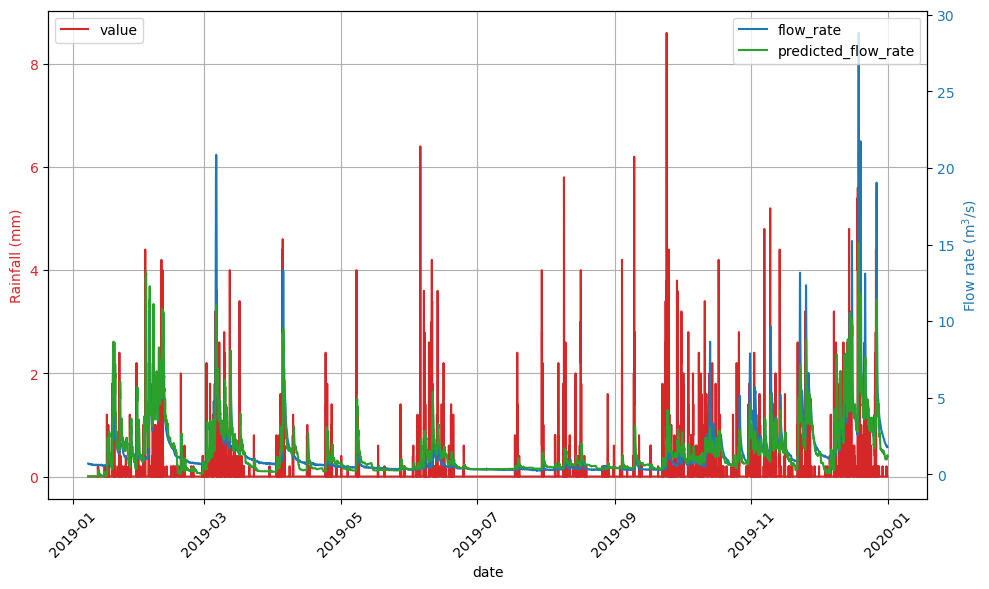

In [75]:
predictions = model.predict(X)
df_results = X
df_results['value'] = df_merged['value'].values
df_results['predicted_flow_rate'], df_results['flow_rate'] = predictions, y
plot_index_3(df_results, df_results, df_results, 'value', 'flow_rate', 'predicted_flow_rate')

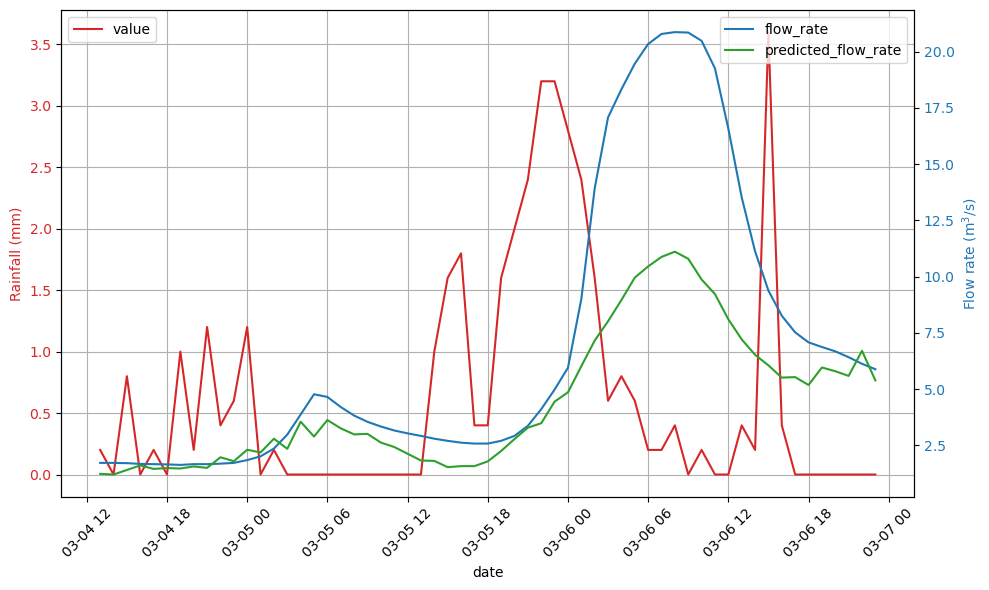

In [76]:
df_filtered_hrs = filter2019_1tab(df_results, 'value', 'flow_rate',  '2019-03-04 12:00:00', '2019-03-07 00:00:00')
plot_index_3(df_filtered_hrs, df_filtered_hrs, df_filtered_hrs, 'value', 'flow_rate', 'predicted_flow_rate')

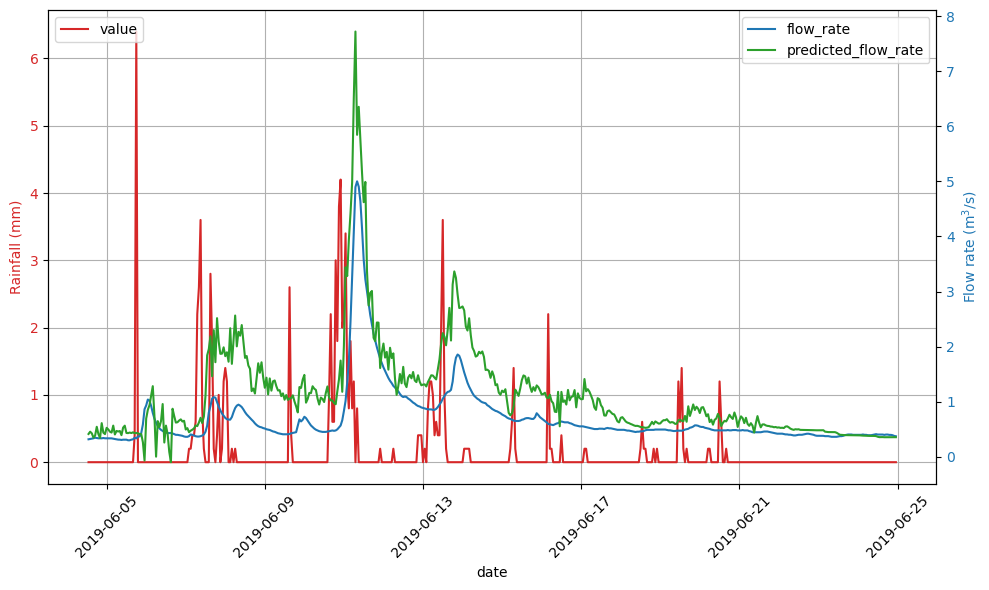

In [90]:
df_filtered_hrs = filter2019_1tab(df_results, 'value', 'flow_rate',  '2019-06-04 12:00:00', '2019-06-25 00:00:00')
plot_index_3(df_filtered_hrs, df_filtered_hrs, df_filtered_hrs, 'value', 'flow_rate', 'predicted_flow_rate')

This has significantly improved the models performance however there is still a lot of room for improvement. 

In the following section I will explore using non linear models on the data to see how they perform.


## 8.0 Non Linear Models

Lets start by using a 2nd order non linear regression.

In [98]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)

X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.3, random_state=42)

X_poly = poly.fit_transform(X_train)

In [99]:
model = LinearRegression()
model.fit(X_poly, y_train)

LinearRegression()

In [94]:
new_data_poly = poly.transform(X_test)

In [95]:
predicted_flow = model.predict(new_data_poly)

In [100]:
# model evaluation 
print('mean_squared_error : ', mean_squared_error(y_test, predicted_flow)) 
print('mean_absolute_error : ', mean_absolute_error(y_test, predicted_flow))

mean_squared_error :  9.524663461618775e-26
mean_absolute_error :  4.765531129785801e-14


In [101]:
X = X[feature_columns]
X['air_temperature_avr'] = df_merged['air_temperature_avr']
X_poly = poly.transform(X)
predicted = model.predict(X_poly)
print('mean_squared_error : ', mean_squared_error(y, predicted)) 
print('mean_absolute_error : ', mean_absolute_error(y, predicted))

mean_squared_error :  0.772351387826206
mean_absolute_error :  0.35627488126236473


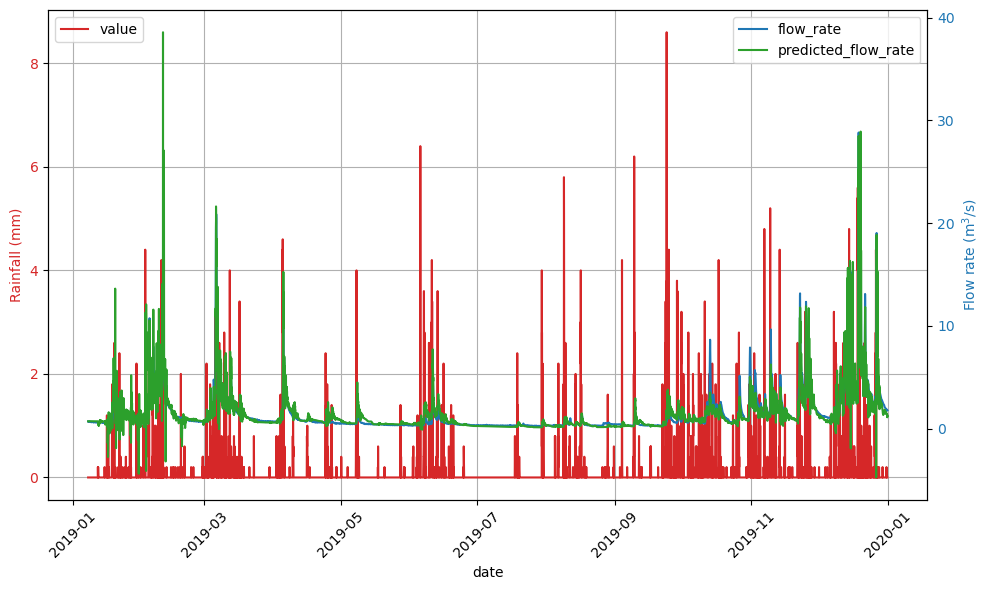

In [87]:
df_results = X
df_results['value'] = df_merged['value'].values
df_results['predicted_flow_rate'], df_results['flow_rate'] = predicted, y
plot_index_3(df_results, df_results, df_results, 'value', 'flow_rate', 'predicted_flow_rate')

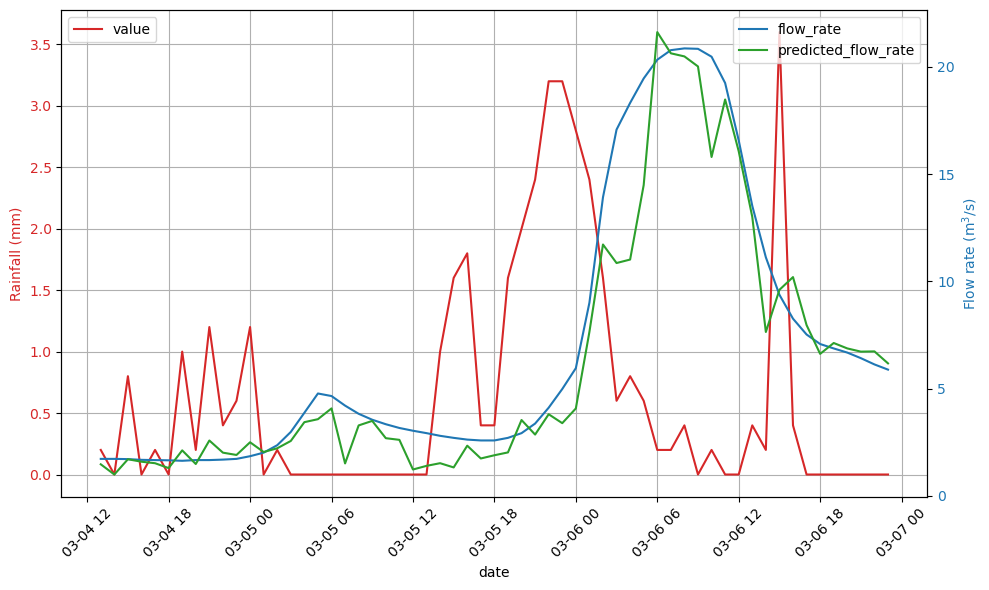

In [102]:
df_filtered_hrs = filter2019_1tab(df_results, 'value', 'flow_rate',  '2019-03-04 12:00:00', '2019-03-07 00:00:00')
plot_index_3(df_filtered_hrs, df_filtered_hrs, df_filtered_hrs, 'value', 'flow_rate', 'predicted_flow_rate')

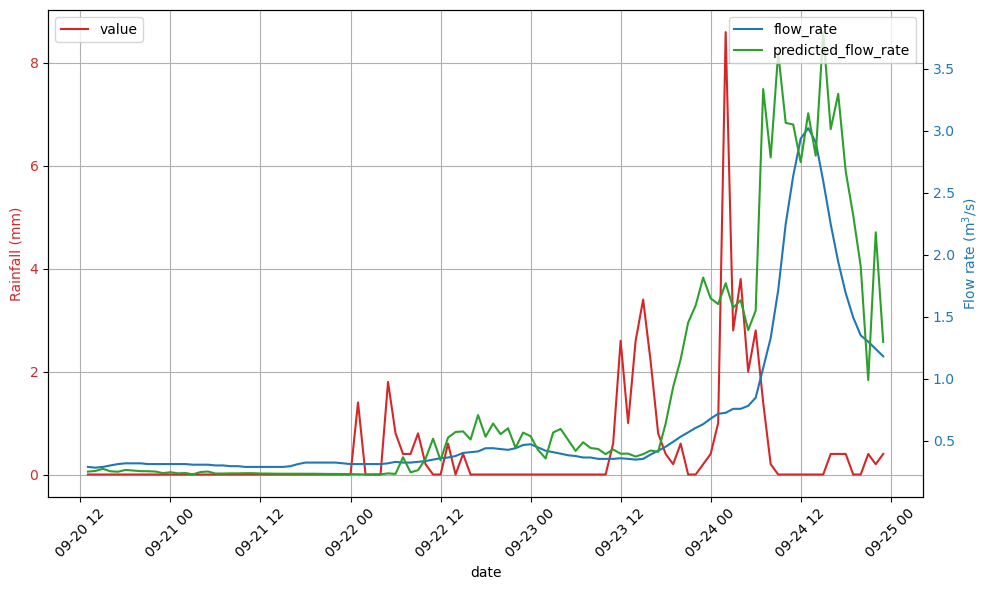

In [103]:
df_filtered_hrs = filter2019_1tab(df_results, 'value', 'flow_rate',  '2019-09-20 12:00:00', '2019-09-25 00:00:00')
plot_index_3(df_filtered_hrs, df_filtered_hrs, df_filtered_hrs, 'value', 'flow_rate', 'predicted_flow_rate')

This an interesting result as the model performs much better over all but there are some significant divergences. Particularly the generation of negative flow values. This non linear model seems to perform a lot better at predicting peak values although there is still some variation with winter under estimation and summer over estimation.

## 9.0 Random forest regression

In [104]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [105]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the Random Forest model
random_forest_model = RandomForestRegressor(n_estimators=200, random_state=42)  # 200 trees in the forest
random_forest_model.fit(X_train, y_train)

# Predicting the test set results
y_pred = random_forest_model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R² (coefficient of determination):", r2)

Mean Squared Error: 0.49833756476480295
R² (coefficient of determination): 0.8445676554800114


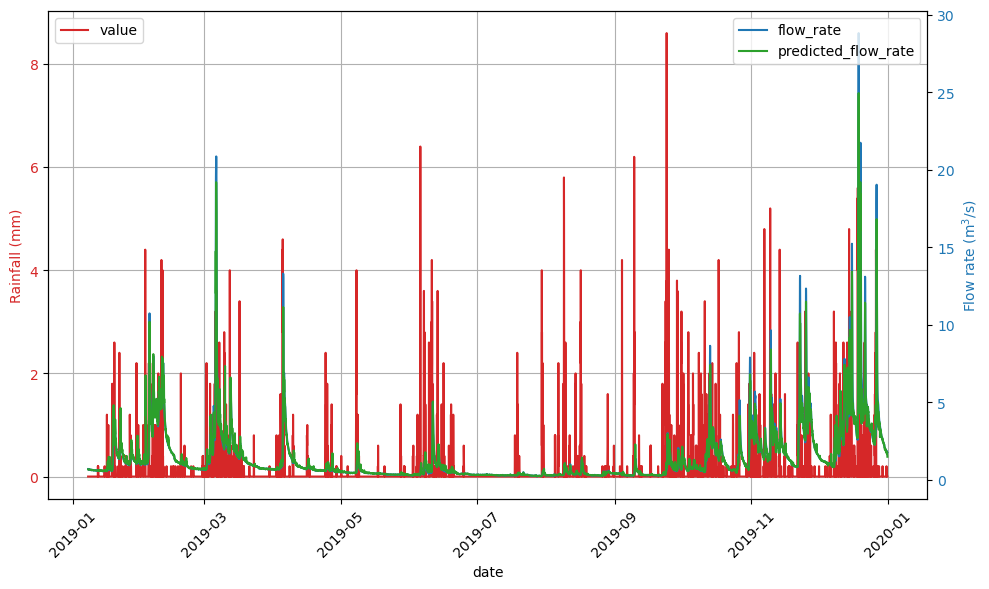

In [106]:
predicted = random_forest_model.predict(X)
df_results = X.copy()
df_results['value'] = df_merged['value'].values
df_results['predicted_flow_rate'], df_results['flow_rate'] = predicted, y
plot_index_3(df_results, df_results, df_results, 'value', 'flow_rate', 'predicted_flow_rate')

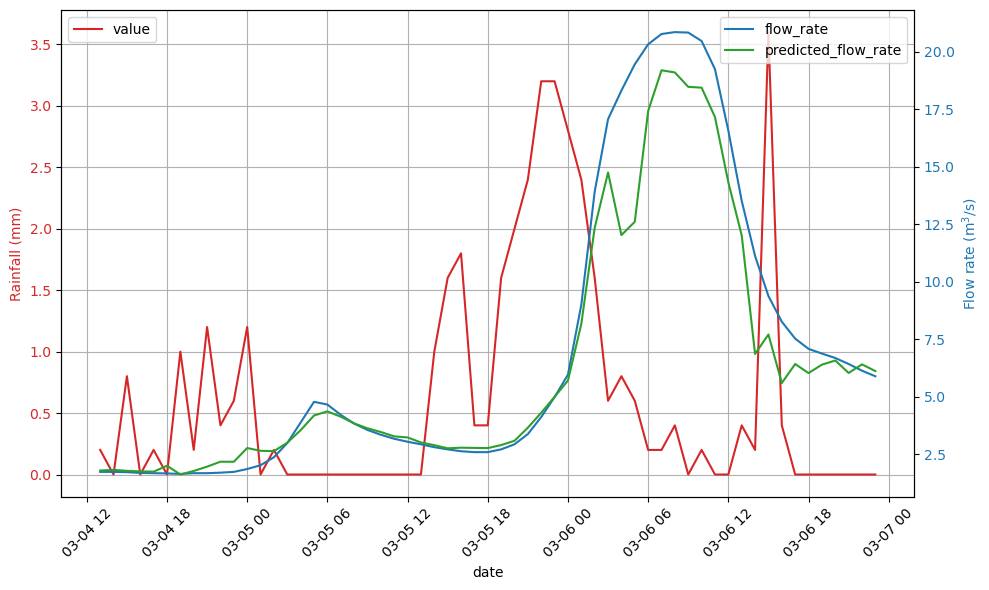

In [107]:
df_filtered_hrs = filter2019_1tab(df_results, 'value', 'flow_rate',  '2019-03-04 12:00:00', '2019-03-07 00:00:00')
plot_index_3(df_filtered_hrs, df_filtered_hrs, df_filtered_hrs, 'value', 'flow_rate', 'predicted_flow_rate')

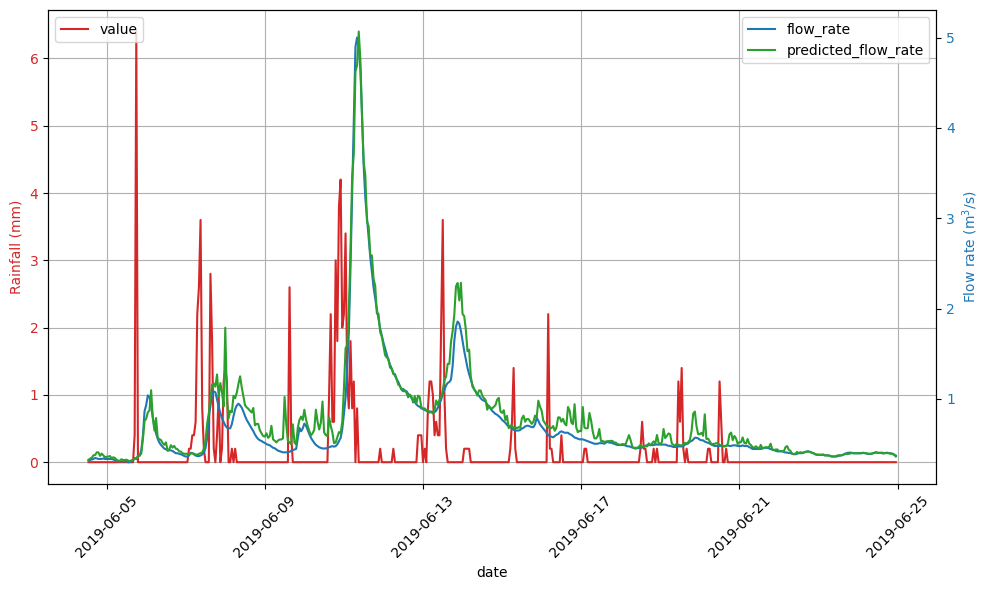

In [108]:
df_filtered_hrs = filter2019_1tab(df_results, 'value', 'flow_rate',  '2019-06-04 12:00:00', '2019-06-25 00:00:00')
plot_index_3(df_filtered_hrs, df_filtered_hrs, df_filtered_hrs, 'value', 'flow_rate', 'predicted_flow_rate')

#### OK now this seems to be quite accurate!

It also doesn't have any strange quirks like producing negative flow rates. The main errors seem to occur at peak flow rates. This may be an issue of your aim was to predict the peak flow rate. A bit of a rough solution could be just adding a bit to the peak values as, from the graph, it seems to be a fairly consistent % error. Another option could be to train the model on high rainfall data only and to go through the data in detail to remove inconsistent and erroneous data. Random forest regression is known for being able to handle noise in the data so removing erroneous data might not yeild much improvement. 

Lets try using a recurrent neural network and see how this compares. 


## 10.0 Recurrent Neural Networks

In [109]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense


# shuffle the data with index attached so index can be preserved
shuffled_X = X.sample(frac=1, random_state=42)
shuffled_y = y.sample(frac=1, random_state=42)

# Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(shuffled_X)

# Split the data
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X_scaled, shuffled_y, shuffled_X.index, test_size=0.2, random_state=42, shuffle=False)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1)

# Predict and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

Epoch 1/200


C:\Users\User\miniconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - loss: 3.9648
Epoch 2/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 1.8793
Epoch 3/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 1.2565
Epoch 4/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 1.1985
Epoch 5/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 1.2562
Epoch 6/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 1.2337
Epoch 7/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 1.1991
Epoch 8/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 1.4500
Epoch 9/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 1.1482
Epoch 10/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 1.1561
Epoch 11/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 1.4834
Epoch 12/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 1.4082
Epoch 13/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 1.1340
Epoch 14/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 1.0770
Epoch 15/200
215/215 ━━━━━━

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 0.3370
Epoch 157/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 0.3718
Epoch 158/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 0.3416
Epoch 159/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 0.3616
Epoch 160/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 0.3606
Epoch 161/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 0.3491
Epoch 162/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 0.3479
Epoch 163/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 0.3458
Epoch 164/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 0.3406
Epoch 165/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 0.3616
Epoch 166/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 0.3504
Epoch 167/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 0.3572
Epoch 168/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 0.3814
Epoch 169/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 0.3355
Epoch 

In [110]:
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
predicted = model.predict(X_scaled)
y_pred_df = pd.DataFrame(predicted, index=shuffled_X.index.values, columns=['predicted_flow_rate'])

269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step


In [111]:
y_pred_df = y_pred_df.sort_index()

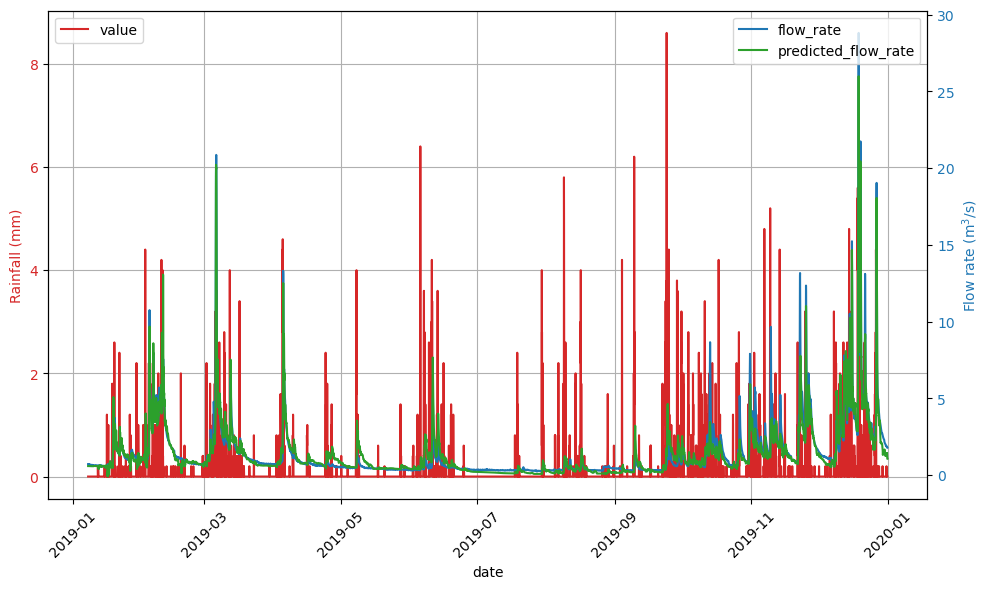

In [112]:
df_results = X.copy()
df_results['value'] = df_merged['value'].values
df_results['flow_rate'] = y
df_results['predicted_flow_rate'] = y_pred_df['predicted_flow_rate']
plot_index_3(df_results, df_results, df_results, 'value', 'flow_rate', 'predicted_flow_rate')

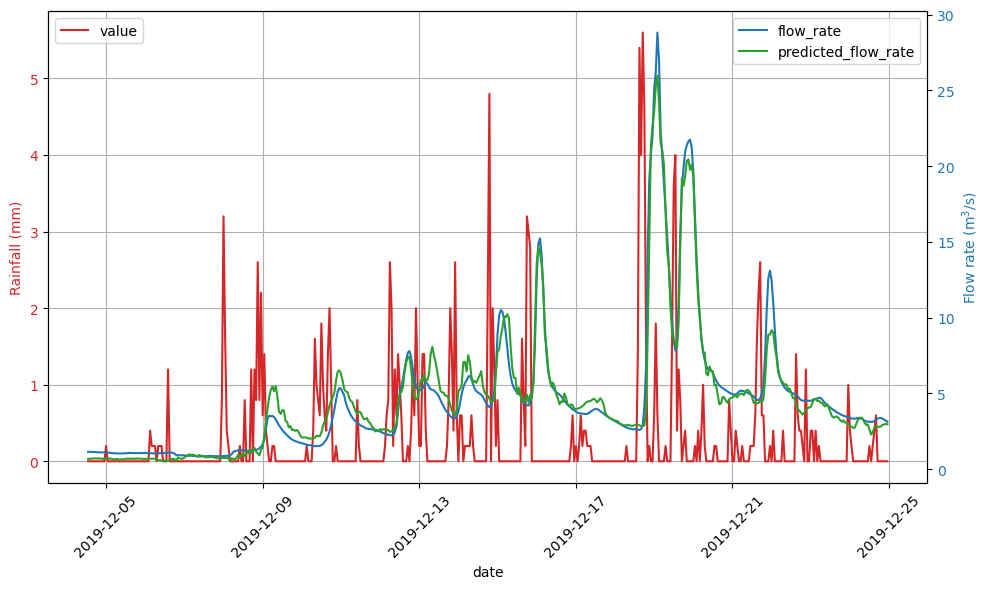

In [113]:
df_filtered_hrs = filter2019_1tab(df_results, 'value', 'flow_rate',  '2019-12-04 12:00:00', '2019-12-25 00:00:00')
plot_index_3(df_filtered_hrs, df_filtered_hrs, df_filtered_hrs, 'value', 'flow_rate', 'predicted_flow_rate')

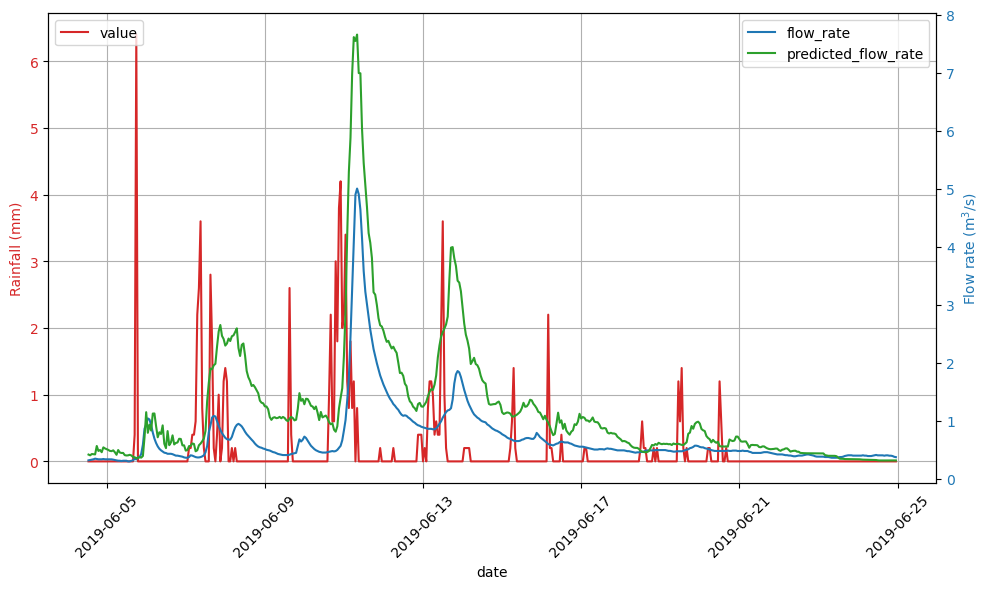

In [114]:
df_filtered_hrs = filter2019_1tab(df_results, 'value', 'flow_rate',  '2019-06-04 12:00:00', '2019-06-25 00:00:00')
plot_index_3(df_filtered_hrs, df_filtered_hrs, df_filtered_hrs, 'value', 'flow_rate', 'predicted_flow_rate')

Ok Now this also looks quite accurate although it seems like there are a few instances of negative flow rates again and over all the results seem a little bit worse than the random forest regression. 

The negative flow rate is likely due to the model being over fit to the data, which is messy. This could be reduced by reducing the number of epochs in the model.fit() hyperparameters. One clue to the data being over fit is the fact that at higher epochs there is not much change in the loss between each epoch. Another option is using the 'recurrent_dropout' hyperparameter to control the amount of neurons that are switched off each time the data is passed through the neurons.

## 11.0 Conclusion

#### 11.1 Executive summary


I initially set out to build a predictive model of flow rate in a river based on rainfall data. 

I was able to identify that flow rate displayed a lagged response to rainfall and there was a seasonal difference in how flow rate responded to rainfall. I was able to create lagged features that would enable predictions to made from a single row of data. I created a term from previous temperature data that I used to modify rainfall throughout the season that significantly improved predictions. I tried a range of machine learning techniques using the sklearn and tensorflow python libraries and I was able to create an accurate model that can be used to predict the flow rate in a river from rainfall data.


#### 11.2 Extended summary

This project aimed to create a predictive model for flow rate in a river using rainfall data from a nearby weather station. The benefit of this approach is that it has the potential to save significant time and resouces in maping and modeling the catchment.

In this document I have used an API to request data from an external database. I have produced visualisations using pythons Matplotlib and seaborn libraries and I used statistical measures to understand the data. 

From the data collected and visualised it was evident that there was a time lagged response of flow rate to rainfall. For this reason I identified that to make a prediction I would need to know what had been happening prior to the time of prediction. I devised a method of creating features for every row of data that would capture information about the rainfall prior to the time of prediction. I initially applied a simple linear regression which when combined with the time lagged features was able to mimic the behaviour of the model at the right time but not at the correct amplitude.

I recognised that there was seasonality to the flow rates response to rainfall and that the model would require additional information if it was going to be able to reflect this seasonal difference in response. I identified that temperature is a good way of measuring seasonality and it seemed to approximately correspond to the change in behaviour of the model. I identified that inverting the temperature data and multiplying rainfall by this factor produced predictions that were significantly improved. 

I tried using a range of machine learning models and identified that random forest regression was the most accurate. This is most likely because it does not over fit the data and there is likely to be some noise and possibly inaccuracy in the data. The random forest regression model produces results that are arguably at a usable level of accuracy so this has been a successful outcome.

Sources of inaccuracy in the data include that the rain gauge where the rainfall data was obtained is not exactly in the catchment of the river so there maybe times when the rainfall is different to the real catchment and rainfall may not be even across the catchment. It is my plan to go back through the data and identify when there is a miss match in cumulative rainfall and volume of flow over a specific time period. There are also times when water is extracted from the river or discharged to the river so this can be accounted for. Filtering out this data should improve the models predictive accuracy. 
